In [1]:
library(tidyverse)
library(ggplot2)
library(nycflights13)
options(repr.plot.width = 10, repr.plot.height = 6)
# httr::set_config(config(ssl_verifypeer = 0L))
# -k means don't verify cert, -L means follow redirects (important for some servers)
options(download.file.method="curl", download.file.extra="-k -L")
theme_set(theme_minimal())

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# STATS 504
## Week 1: TransStats data

## TransStats
- [U.S. Bureau of Transportation Statistics](http://www.transtats.bts.gov)
- Aviation, maritime, highway, transit, and rail.
- We will focus on aviation today

## Three questions for lecture
For today's lecture I want to answer the following questions:

- Which airlines are likely to cancel a flight during spring break?
- Where do people fly to from Detroit in the winter?

## Getting the data
- The web site has interactive query builders for the different data bases.
- Example: [airline on-time data](https://www.transtats.bts.gov/Tables.asp?QO_VQ=EFD&QO_anzr=Nv4yv0r%FDb0-gvzr%FDcr4s14zn0pr%FDQn6n&QO_fu146_anzr=b0-gvzr)
- The interface lets you download one month of data at a time -- how to automate?

In [2]:
base <- 'https://www.transtats.bts.gov/PREZIP/'

template <- paste0(base, 'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip')


template %>% str_glue(year=2020, month=3)

https://www.transtats.bts.gov/PREZIP/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2020_3.zip

In [24]:
## Downloading a data file
# template %>% str_glue(year=2023, month=5) %>% download.file("2023_05.zip")
df <- read_csv("2023_05.zip") 
df %>% head


Multiple files in zip: reading 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2023_5.csv'
New names:
• `` -> `...110`
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 579958 Columns: 110
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (27): Reporting_Airline, IATA_CODE_Reporting_Airline, Tail_Number, Orig...
dbl  (49): Year, Quarter, Month, DayofMonth, DayOfWeek, DOT_ID_Reporting_Air...
lgl  (33): Div2Airport, Div2AirportID, Div2AirportSeqID, Div2WheelsOn, Div2T...
date  (1): FlightDate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,⋯,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,...110
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<chr>,<dbl>,<chr>,<chr>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
2023,2,5,14,7,2023-05-14,9E,20363,9E,N491PX,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2023,2,5,21,7,2023-05-21,9E,20363,9E,N931XJ,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2023,2,5,28,7,2023-05-28,9E,20363,9E,N482PX,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2023,2,5,1,1,2023-05-01,9E,20363,9E,N335PQ,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2023,2,5,2,2,2023-05-02,9E,20363,9E,N200PQ,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2023,2,5,3,3,2023-05-03,9E,20363,9E,N600LR,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Assembling the dataset
Let's download all the data from 2022 (the most recent complete year).


Each `.zip` file contains a README describing the column layout. From this, I build the following column specification to extract only the data I need:

In [25]:
columns <- cols_only(
  FlightDate = col_datetime(),
  Tail_Number = col_character(),
  Reporting_Airline = col_character(),
  Origin = col_character(),
  Dest = col_character(),
  DepTime = col_double(),
  DepDelay = col_double(),
  ArrTime = col_double(),
  ArrDelay = col_double(),
  Cancelled = col_double(),
  CancellationCode = col_character(),
  AirTime = col_double(),
  Distance = col_double(),
  CarrierDelay = col_double(),
  WeatherDelay = col_double(),
  NASDelay = col_double(),
  SecurityDelay = col_double(),
  LateAircraftDelay = col_double()
)

## Data download function
- Now I want to download the data for 2022-1, 2022-2, ..., 2022-12 in succession and paste them together.
- Since we're going to be applying the same code twelve different times, it makes sense to package this code up into a function and re-use it.
- Guiding principle: don't repeat yourself! ([DRY](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself))

In [26]:
dl_data <- function(month, year) {
    fn <- paste0(year, "_", month, ".zip")
    if (! file.exists(fn)) {
        str_glue(template, year=year, month=month) %>% download.file(fn)
    }
    return(read_csv(fn, col_types = columns))
}

In [1]:
# It will take some time.  Not going to run 
# download and read the data
#map_dfr(1:12, ~ dl_data(.x, 2022))

In [2]:
#flights_2022 <- map_dfr(1:12, \(m) dl_data(m, 2022))


In [59]:
# save for later use, to prevent having to re-download and reprocess everything
 save(flights_2022, file="flights_2022.RData")
#load("flights_2023.RData")

In [60]:
flights_2022 %>% print

# A tibble: 6,729,125 × 18
   FlightDate          Reporting_Airline Tail_Number Origin Dest  DepTime
   <dttm>              <chr>             <chr>       <chr>  <chr>   <dbl>
 1 2022-01-14 00:00:00 YX                N119HQ      CMH    DCA      1221
 2 2022-01-15 00:00:00 YX                N122HQ      CMH    DCA      1214
 3 2022-01-16 00:00:00 YX                N412YX      CMH    DCA      1218
 4 2022-01-17 00:00:00 YX                N405YX      CMH    DCA      1217
 5 2022-01-18 00:00:00 YX                N420YX      CMH    DCA      1218
 6 2022-01-19 00:00:00 YX                N446YX      CMH    DCA      1219
 7 2022-01-20 00:00:00 YX                N116HQ      CMH    DCA      1217
 8 2022-01-21 00:00:00 YX                N419YX      CMH    DCA      1220
 9 2022-01-22 00:00:00 YX                N137HQ      CMH    DCA      1220
10 2022-01-23 00:00:00 YX                N110HQ      CMH    DCA      1223
# ℹ 6,729,115 more rows
# ℹ 12 more variables: DepDelay <dbl>, ArrTime <dbl>, ArrDela

## Who is most likely to cancel flights

- I am worried about my flight getting cancelled. Which air carrier is most likely to cancel?
- How should we we measure? Ideas:
    - Total Cancellations / Total Scheduled Flights.
    - Some cancellations are due to circumstances beyond the carrier's control (e.g. weather). 
    - Route specific cancellations: are some routes more likely to get cancelled?
    - Benchmark: compare an airline's cancellation rate against the industry average.

In [32]:
flights_2022 %>% print

# A tibble: 6,847,899 × 18
   FlightDate          Reporting_Airline Tail_Number Origin Dest  DepTime
   <dttm>              <chr>             <chr>       <chr>  <chr>   <dbl>
 1 2023-01-02 00:00:00 9E                N605LR      BDL    LGA       757
 2 2023-01-03 00:00:00 9E                N605LR      BDL    LGA       755
 3 2023-01-04 00:00:00 9E                N331PQ      BDL    LGA       755
 4 2023-01-05 00:00:00 9E                N906XJ      BDL    LGA       754
 5 2023-01-06 00:00:00 9E                N337PQ      BDL    LGA       759
 6 2023-01-07 00:00:00 9E                N336PQ      BDL    LGA       750
 7 2023-01-14 00:00:00 9E                N311PQ      LGA    CVG      1452
 8 2023-01-21 00:00:00 9E                N917XJ      LGA    CVG      1450
 9 2023-01-28 00:00:00 9E                N336PQ      LGA    CVG      1455
10 2023-01-09 00:00:00 9E                N491PX      LGA    BGM      2122
# ℹ 6,847,889 more rows
# ℹ 12 more variables: DepDelay <dbl>, ArrTime <dbl>, ArrDela

## Basic analysis
Let us start by analyzing the overall cancellation rate.

In [33]:
# Airline names 
nycflights13::airlines %>% print

# A tibble: 16 × 2
   carrier name                       
   <chr>   <chr>                      
 1 9E      Endeavor Air Inc.          
 2 AA      American Airlines Inc.     
 3 AS      Alaska Airlines Inc.       
 4 B6      JetBlue Airways            
 5 DL      Delta Air Lines Inc.       
 6 EV      ExpressJet Airlines Inc.   
 7 F9      Frontier Airlines Inc.     
 8 FL      AirTran Airways Corporation
 9 HA      Hawaiian Airlines Inc.     
10 MQ      Envoy Air                  
11 OO      SkyWest Airlines Inc.      
12 UA      United Air Lines Inc.      
13 US      US Airways Inc.            
14 VX      Virgin America             
15 WN      Southwest Airlines Co.     
16 YV      Mesa Airlines Inc.         


In [61]:
# group flights by airline
# calculate average cancellation rate for each airline
# join the table with nycflights13 to get airline names
# sort with descending order


flights_2022 %>%
  group_by(Reporting_Airline) %>%
  summarize(
    cr = mean(Cancelled),
    n = n()
  ) %>%
  left_join(nycflights13::airlines, by = c("Reporting_Airline" = "carrier")) %>%
  arrange(desc(cr))



Reporting_Airline,cr,n,name
<chr>,<dbl>,<int>,<chr>
YX,0.046953785,316524,NA
B6,0.037424283,273058,JetBlue Airways
9E,0.035362441,231941,Endeavor Air Inc.
G4,0.035165174,116877,NA
YV,0.033194225,114779,Mesa Airlines Inc.
WN,0.032632087,1307149,Southwest Airlines Co.
OH,0.030832362,214450,NA
NK,0.030004303,232400,NA
AA,0.029622088,874145,American Airlines Inc.


This has revealed a problem in our data. The join did not perform as we expected.

In [62]:
#Joins flights_2023 with airline names using Reporting_Airline → carrier
#Filters for rows where no airline name was found (is.na(name))
#Counts how many such unmatched entries exist per Reporting_Airline

flights_2022 %>%
  left_join(nycflights13::airlines, by = c("Reporting_Airline" = "carrier")) %>% 
  filter(is.na(name)) %>% 
  count(Reporting_Airline)

Reporting_Airline,n
<chr>,<int>
G4,116877
NK,232400
OH,214450
QX,88791
YX,316524


Incidentally, this is an argument for using `left_join` instead of `inner_join`. Inner join would have silently eliminated all the non-matching rows. We would have no idea that we were missing out on hundreds of thousands of flights.

## Scraping
We need a quick way to get an up-to-date database of airline codes.
- Wikipedia has a list [here](https://en.wikipedia.org/wiki/List_of_airline_codes).
- How can we get this into R?

In [36]:
#install.packages("rvest")
library(rvest)
read_html('https://en.wikipedia.org/wiki/List_of_airline_codes') %>% html_table %>% .[[1]] ->
    airline_codes

In [37]:
airline_codes %>% print

# A tibble: 6,346 × 6
   IATA  ICAO  Airline                     `Call sign` `Country/Region` Comments
   <chr> <chr> <chr>                       <chr>       <chr>            <chr>   
 1 "PR"  "BOI" 2GO                         "ABAIR"     "Philippines"    ""      
 2 ""    "EVY" 34 Squadron, Royal Austral… "Multiple"  ""               ""      
 3 ""    "GNL" 135 Airways                 "GENERAL"   "United States"  ""      
 4 "1A"  "n/a" Amadeus IT Group S.A.       "n/a"       "Global"         "GDS an…
 5 "1B"  "n/a" Sabre travel network Asia-… "n/a"       "APAC"           "Region…
 6 "1E"  "n/a" Travelsky                   "n/a"       "China"          "Local …
 7 "1F"  "n/a" Infini travel information,… "n/a"       "Japan"          "Local …
 8 "1G"  "n/a" Travelport (Galileo core)   "n/a"       "Global"         "GDS (C…
 9 "1H"  "n/a" Sirena travel               "n/a"       "Russia"         "Local …
10 "1J"  ""    PT. Navios Evolusi Solusin… ""          "Indonesia"      ""      
# ℹ 6,

Warning message in left_join(., airline_codes, join_by(Reporting_Airline == IATA)):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 4051 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


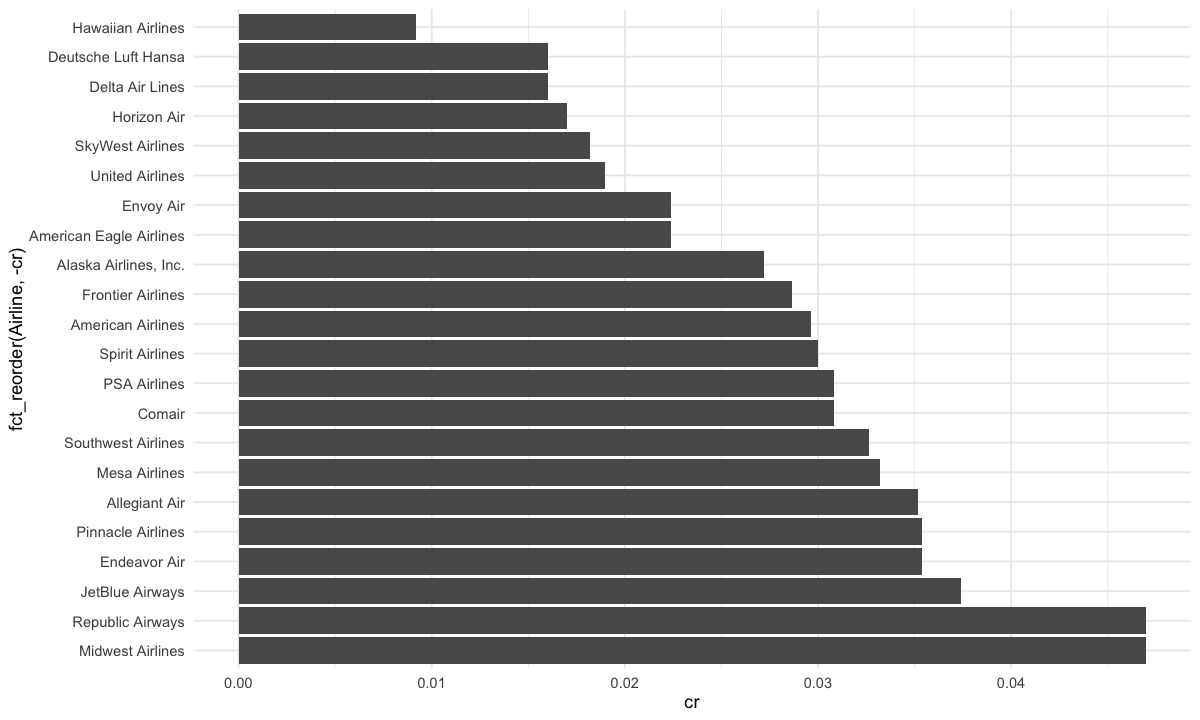

In [63]:
flights_2022 %>%
    left_join(airline_codes, join_by(Reporting_Airline == IATA)) %>% 
    group_by(Airline) %>% summarize(cr = mean(Cancelled)) %>%
    ggplot + geom_col(aes(x = fct_reorder(Airline, -cr), y = cr)) + coord_flip()


What about the warning we received?

In [69]:
filter(airline_codes, IATA == "MQ")

IATA,ICAO,Airline,Call sign,Country/Region,Comments
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
MQ,EGF,American Eagle Airlines,EAGLE FLIGHT,United States,"Renamed Envoy Air, ICAO Code and Callsign withdrawn in 2014"
MQ,ENY,Envoy Air,ENVOY,United States,2014[19]


In [70]:
airline_codes %>% filter(! ICAO %in% c("COM", "EGF", "FLG")) -> ac_us_filt
flights_2022 %>%
    group_by(Reporting_Airline) %>% 
    summarize(cr = mean(Cancelled)) %>% 
    top_n(3, cr) -> worst_2022

worst_2022 %>% print

# A tibble: 3 × 2
  Reporting_Airline     cr
  <chr>              <dbl>
1 9E                0.0354
2 B6                0.0374
3 YX                0.0470


## Cancellation rate by week
- Let's consider cancellations by week of the year.
- Are cancellations more likely during some periods of the year than others?

`summarise()` has grouped output by 'Reporting_Airline'. You can override using
the `.groups` argument.


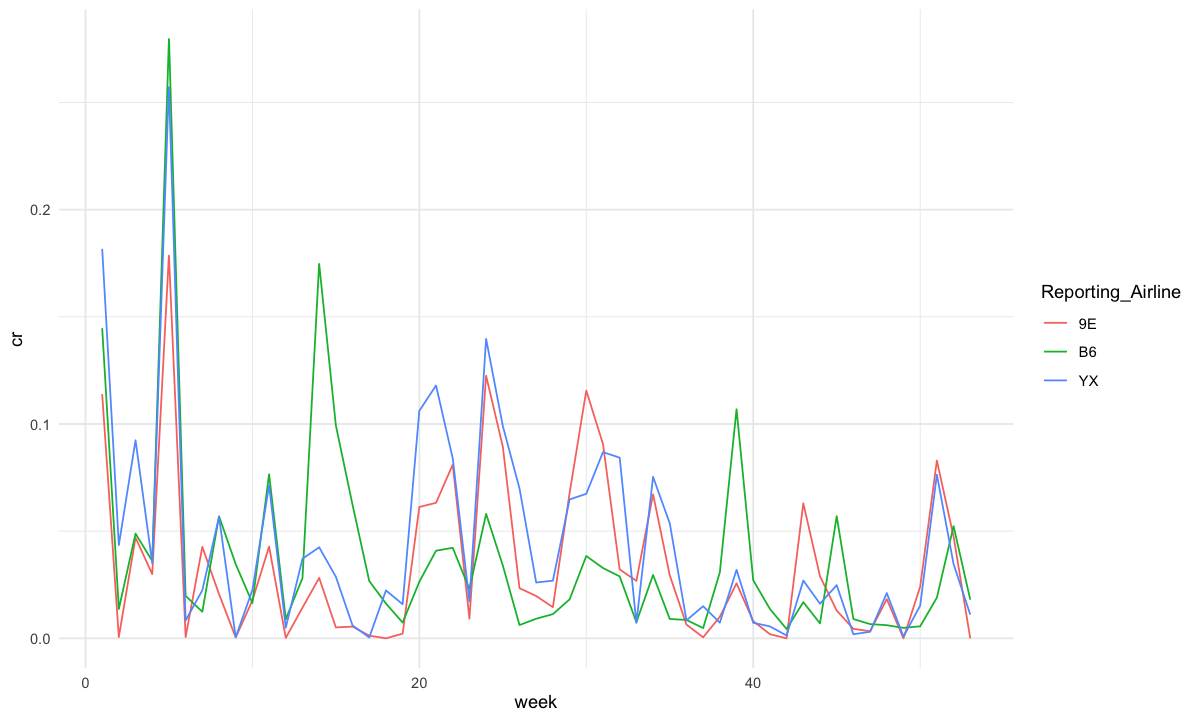

In [71]:
flights_2022 %>% mutate(week = lubridate::week(FlightDate)) %>% group_by(Reporting_Airline, week) %>% 
    summarize(cr = mean(Cancelled), n = n()) %>% 
    semi_join(worst_2022, join_by(Reporting_Airline)) %>% 
    ggplot + geom_line(aes(x = week, y = cr, color = Reporting_Airline))

This plot is sort of hard to read, so let's think of same ways to improve it:
- Plot carrier name instead of code.
- Consider deviation from average weekly delay.

`summarise()` has grouped output by 'wk'. You can override using the `.groups`
argument.


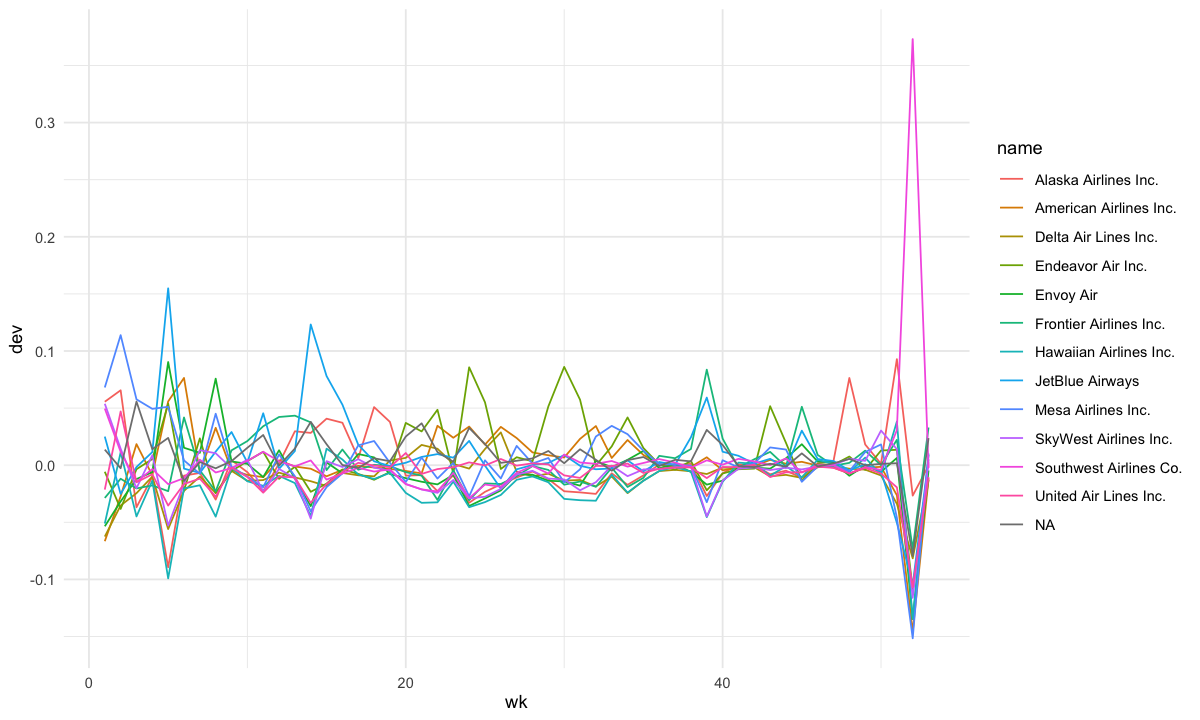

In [72]:
flights_2022 %>% mutate(wk = lubridate::week(FlightDate)) %>% 
    left_join(nycflights13::airlines, join_by(Reporting_Airline == carrier)) %>% 
    group_by(wk, name) %>% 
    summarize(cr = mean(Cancelled), nc = sum(Cancelled), n = n()) %>% 
    mutate(global_rate = sum(nc) / sum(n), dev = cr - global_rate)  %>%
    ggplot + geom_line(aes(x = wk, y = dev, color = name))

(What is the [spike](https://en.wikipedia.org/wiki/2022_Southwest_Airlines_scheduling_crisis) at the very end of 2022?)

The plot is still rather jumbled. We can try zooming in on specific carriers:

In [73]:
flights_2022 %>% mutate(wk = lubridate::week(FlightDate)) %>% 
    left_join(nycflights13::airlines, join_by(Reporting_Airline == carrier)) %>% 
    group_by(wk, name) %>% 
    summarize(cr = mean(Cancelled), nc = sum(Cancelled), n = n()) %>%
    mutate(dev = cr - sum(nc) / sum(n)) %>% 
    filter(name == "Southwest Airlines Co.") -> carrier_cancellations

carrier_cancellations %>% print

`summarise()` has grouped output by 'wk'. You can override using the `.groups`
argument.


# A tibble: 53 × 6
# Groups:   wk [53]
      wk name                        cr    nc     n      dev
   <dbl> <chr>                    <dbl> <dbl> <int>    <dbl>
 1     1 Southwest Airlines Co. 0.169    3751 22162  0.0496 
 2     2 Southwest Airlines Co. 0.0506   1063 20997  0.0117 
 3     3 Southwest Airlines Co. 0.0359    802 22348 -0.0146 
 4     4 Southwest Airlines Co. 0.0212    475 22440 -0.00343
 5     5 Southwest Airlines Co. 0.108    2427 22440 -0.0166 
 6     6 Southwest Airlines Co. 0.0115    257 22440 -0.0113 
 7     7 Southwest Airlines Co. 0.0240    542 22599  0.00481
 8     8 Southwest Airlines Co. 0.0387    897 23186 -0.00638
 9     9 Southwest Airlines Co. 0.00301    69 22925 -0.00258
10    10 Southwest Airlines Co. 0.0179    395 22074  0.00382
# ℹ 43 more rows


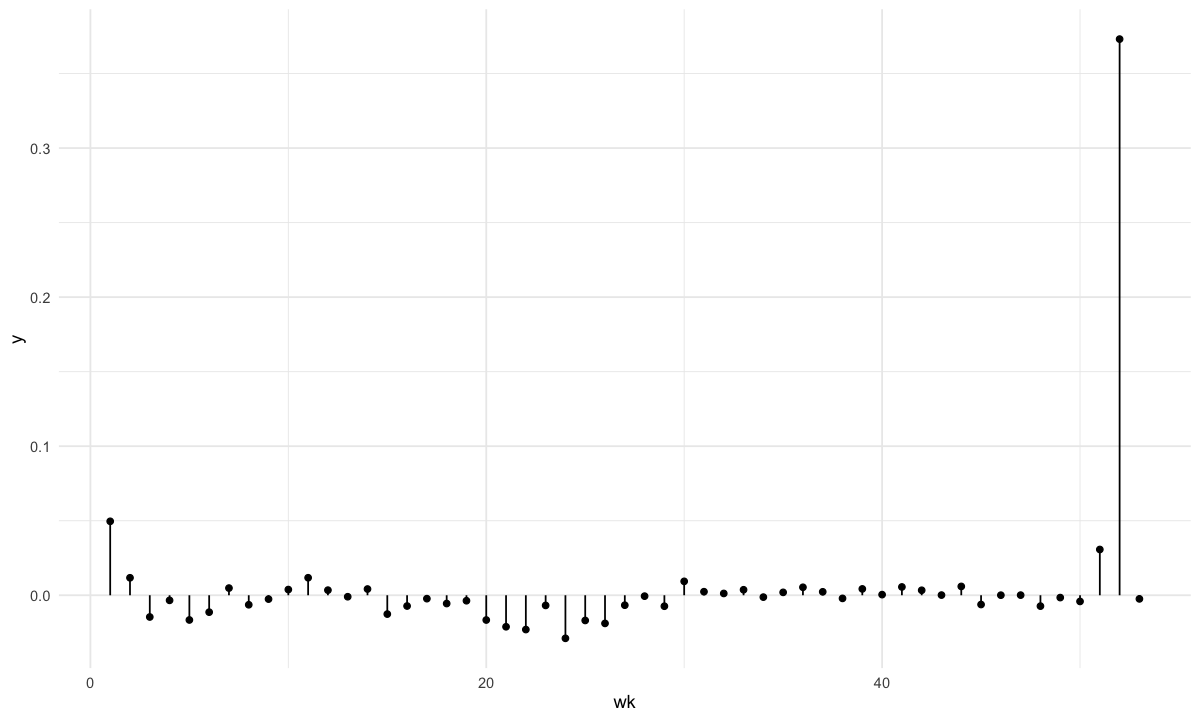

In [74]:
# lollipop plot
carrier_cancellations %>% ggplot + 
    geom_segment(aes(x = wk, xend=wk, y = 0, yend = dev)) +
    geom_point(aes(x = wk, y = dev))

## Reasons for cancellation

- For flights that are cancelled, there is a code:

In [75]:
flights_2022$CancellationCode %>% table

.
    A     B     C     D 
71780 93013 15469  1024 

- [What do the codes mean](https://www.transtats.bts.gov/FieldInfo.asp?Svryq_Qr5p=f2rpvsvr5%FDgur%FDern510%FDS14%FDPn0pryyn6v10&Svryq_gB2r=Pun4&Y11x72_gnoyr=Y_PNaPRYYNgVba&gnoyr_VQ=FGK&flf_gnoyr_anzr=g_bagVZR_ZNeXRgVaT&fB5_Svryq_anzr=PNaPRYYNgVba_PbQR)?

In [1]:
flights_2022 %>% mutate(CancellationCode = fct_recode(
      CancellationCode,
      Carrier = "A",
      Weather = "B",
      "National Air System" = "C",
      Security = "D"
   )
) -> flights_2022a

ERROR: Error in flights_2022 %>% mutate(CancellationCode = fct_recode(CancellationCode, : could not find function "%>%"


- Now we want to visualize the distribution of two categorical variables: `airline` and `cancellation code`.
- How should we do it?
- (Recall last lecture)

In [77]:
(table(flights_2022a$Reporting_Airline, flights_2022a$CancellationCode) -> fl_tbl)

    
     Carrier Weather National Air System Security
  9E    1953    3075                3174        0
  AA    8839   15744                1309        2
  AS    5132    1049                  36        1
  B6    4655    3976                1588        0
  DL    8359    4991                 967        0
  F9    2232    2223                   0        0
  G4    1973    1820                 303       14
  HA     635      45                   0        0
  MQ     785    3884                 881        0
  NK    1630    5081                 262        0
  OH    1231    5223                 158        0
  OO    2230   10047                 809      245
  QX     748     689                  75        0
  UA    5309    5488                 586      503
  WN   22673   17497                2373      112
  YV    1833    1607                 223      147
  YX    1563   10574                2725        0

To make the table more readable, we should normalize the table across:
    - Rows?
    - Columns?

In [79]:
fl_tbl %>% prop.table(1) %>% round(3) # row
#fl_tbl %>% prop.table(2) %>% round(3) # column

    
     Carrier Weather National Air System Security
  9E   0.238   0.375               0.387    0.000
  AA   0.341   0.608               0.051    0.000
  AS   0.825   0.169               0.006    0.000
  B6   0.456   0.389               0.155    0.000
  DL   0.584   0.349               0.068    0.000
  F9   0.501   0.499               0.000    0.000
  G4   0.480   0.443               0.074    0.003
  HA   0.934   0.066               0.000    0.000
  MQ   0.141   0.700               0.159    0.000
  NK   0.234   0.729               0.038    0.000
  OH   0.186   0.790               0.024    0.000
  OO   0.167   0.754               0.061    0.018
  QX   0.495   0.456               0.050    0.000
  UA   0.447   0.462               0.049    0.042
  WN   0.532   0.410               0.056    0.003
  YV   0.481   0.422               0.059    0.039
  YX   0.105   0.711               0.183    0.000

## Where do people in Michigan fly during the winter?

To study this, we will use a random 10% sample of all airline tickets issued during Q12023:

https://www.transtats.bts.gov/DatabaseInfo.asp?QO_VQ=EFI&Yv0x=D

In [3]:
# tkt_2023 <- read_csv('Origin_and_Destination_Survey_DB1BMarket_2023_1.zip')
# save(tkt_2023, file="tkt_2023.RData")
 load("tkt_2023.RData")

In [6]:
#tkt_2023%>%print
tkt_2023%>%glimpse

Rows: 6,714,113
Columns: 42
$ ItinID             <dbl> 2.02313e+11, 2.02313e+11, 2.02313e+11, 2.02313e+11,…
$ MktID              <dbl> 2.02313e+13, 2.02313e+13, 2.02313e+13, 2.02313e+13,…
$ MktCoupons         <dbl> 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ Year               <dbl> 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 202…
$ Quarter            <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ OriginAirportID    <dbl> 14843, 13577, 13577, 13577, 13577, 13577, 13577, 13…
$ OriginAirportSeqID <dbl> 1484306, 1357702, 1357702, 1357702, 1357702, 135770…
$ OriginCityMarketID <dbl> 34819, 31135, 31135, 31135, 31135, 31135, 31135, 31…
$ Origin             <chr> "SJU", "MYR", "MYR", "MYR", "MYR", "MYR", "MYR", "M…
$ OriginCountry      <chr> "US", "US", "US", "US", "US", "US", "US", "US", "US…
$ OriginStateFips    <chr> "72", "45", "45", "45", "45", "45", "45", "45", "45…
$ OriginState        <chr> "PR", "SC", "SC", "SC", "SC", "SC", "SC", "SC", "SC…
$ OriginStat

In [7]:
tkt_2023 %>% filter(Origin == "DTW") %>% count(DestState) -> dtw_winter_locations

In [8]:
states_abbrs <- data.frame(
  Abbreviation = c("AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
                   "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
                   "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
                   "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
                   "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"),
  StateName = c("Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", 
                "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", 
                "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", 
                "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", 
                "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", 
                "New Hampshire", "New Jersey", "New Mexico", "New York", 
                "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", 
                "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", 
                "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", 
                "West Virginia", "Wisconsin", "Wyoming")
)

#print(states_abbrs)


Joining with `by = join_by(region)`


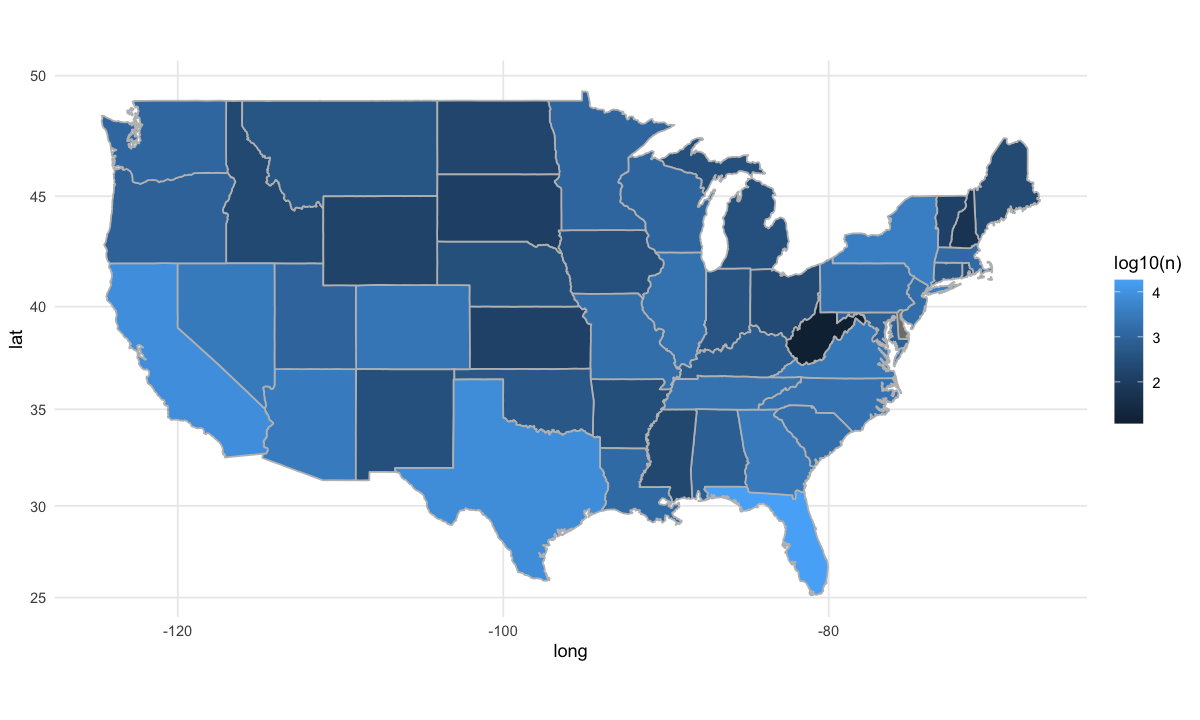

In [12]:

library(maps)

states <- map_data("state")

# states_abbrs

 dtw_2 <- dtw_winter_locations %>% 
     left_join(states_abbrs, by = join_by(DestState == Abbreviation)) %>% 
     mutate(region = str_to_lower(StateName))

states %>% left_join(dtw_2) %>% as_tibble %>% 
    ggplot() + geom_polygon(aes(x = long, y = lat, group = group, fill = log10(n)), color = "grey") +
    coord_map()